<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/CRNN_Acc_Class_Cat_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version History

- Dec 1 - Created.
- Dec 2
    - Added folder concat
    - Added model checkpoint saving
    - Added raw train tester
    - Tested on augmented data

## Config

In [ ]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy"

aug = False

if aug:
    train_set_folders = ["ps_1_dur_10_npy",
                         "ps_1_dur_10_npy",
                         "gn_0.05_dur_10_npy"
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [ ]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Base Arch

In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 5, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

    

## Data Gen

Array shape is (27, 1, 13, 431)
13


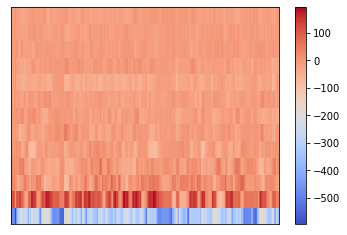

In [ ]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

## Train Func

In [ ]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.squeeze().float().cuda().transpose(1,2)
            # print(input_array.shape)
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_rnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, "_checkpoint_subdir")
        full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
        try:
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        except FileNotFoundError:
            os.makedirs(full_checkpoint_path)
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
    
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

In [ ]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.float().cuda()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, "_checkpoint_subdir")
        full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
        try:
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        except FileNotFoundError:
            os.makedirs(full_checkpoint_path)
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
    
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## Experiments

### Exp 1: Base

Using CUDA
Epoch:  0 Train Accuracy:  0.40272456364410386 Val Accuracy:  0.6111111111111112 Progress:   3.33  % Time Elapsed:  264.76 s 
Epoch 0 Finished.  Time per Epoch:  264.76 s 
Epoch:  1 Train Accuracy:  0.5210727969348659 Val Accuracy:  0.42592592592592593 Progress:   6.67  % Time Elapsed:  286.29 s 
Epoch 1 Finished.  Time per Epoch:  143.14 s 
Epoch:  2 Train Accuracy:  0.5793954874414644 Val Accuracy:  0.42592592592592593 Progress:  10.00  % Time Elapsed:  307.66 s 
Epoch 2 Finished.  Time per Epoch:  102.55 s 
Epoch:  3 Train Accuracy:  0.6083439761600681 Val Accuracy:  0.5 Progress:  13.33  % Time Elapsed:  328.98 s 
Epoch 3 Finished.  Time per Epoch:  82.24 s 
Epoch:  4 Train Accuracy:  0.6398467432950191 Val Accuracy:  0.4444444444444444 Progress:  16.67  % Time Elapsed:  350.29 s 
Epoch 4 Finished.  Time per Epoch:  70.06 s 
Epoch:  5 Train Accuracy:  0.6577266922094508 Val Accuracy:  0.5 Progress:  20.00  % Time Elapsed:  371.45 s 
Epoch 5 Finished.  Time per Epoch:  61

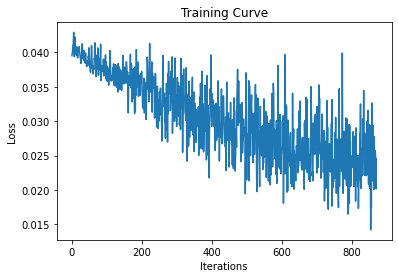

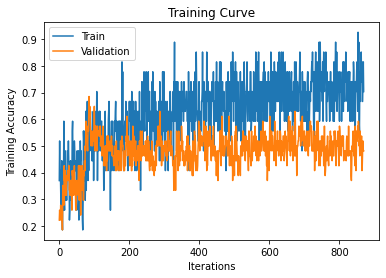

Epoch:  10 Train Accuracy:  0.7445721583652618 Val Accuracy:  0.5555555555555556 Progress:  36.67  % Time Elapsed:  478.12 s 
Epoch 10 Finished.  Time per Epoch:  43.47 s 
Epoch:  11 Train Accuracy:  0.7547892720306514 Val Accuracy:  0.5370370370370371 Progress:  40.00  % Time Elapsed:  499.62 s 
Epoch 11 Finished.  Time per Epoch:  41.63 s 
Epoch:  12 Train Accuracy:  0.7543635589612601 Val Accuracy:  0.4444444444444444 Progress:  43.33  % Time Elapsed:  520.84 s 
Epoch 12 Finished.  Time per Epoch:  40.06 s 
Epoch:  13 Train Accuracy:  0.7633035334184759 Val Accuracy:  0.5370370370370371 Progress:  46.67  % Time Elapsed:  542.02 s 
Epoch 13 Finished.  Time per Epoch:  38.72 s 
Epoch:  14 Train Accuracy:  0.7777777777777778 Val Accuracy:  0.5185185185185185 Progress:  50.00  % Time Elapsed:  563.17 s 
Epoch 14 Finished.  Time per Epoch:  37.54 s 
Epoch:  15 Train Accuracy:  0.789272030651341 Val Accuracy:  0.5185185185185185 Progress:  53.33  % Time Elapsed:  584.49 s 
Epoch 15 Finish

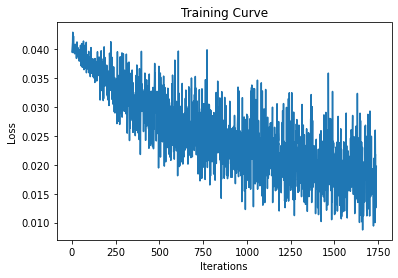

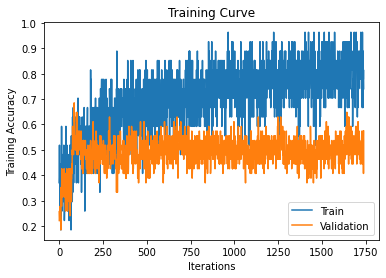

Epoch:  20 Train Accuracy:  0.8177948063005535 Val Accuracy:  0.5925925925925926 Progress:  70.00  % Time Elapsed:  691.15 s 
Epoch 20 Finished.  Time per Epoch:  32.91 s 
Epoch:  21 Train Accuracy:  0.8284376330353341 Val Accuracy:  0.5555555555555556 Progress:  73.33  % Time Elapsed:  712.47 s 
Epoch 21 Finished.  Time per Epoch:  32.39 s 
Epoch:  22 Train Accuracy:  0.8424861643252448 Val Accuracy:  0.5555555555555556 Progress:  76.67  % Time Elapsed:  734.32 s 
Epoch 22 Finished.  Time per Epoch:  31.93 s 
Epoch:  23 Train Accuracy:  0.8420604512558536 Val Accuracy:  0.46296296296296297 Progress:  80.00  % Time Elapsed:  755.63 s 
Epoch 23 Finished.  Time per Epoch:  31.48 s 
Epoch:  24 Train Accuracy:  0.8378033205619413 Val Accuracy:  0.5740740740740741 Progress:  83.33  % Time Elapsed:  776.97 s 
Epoch 24 Finished.  Time per Epoch:  31.08 s 
Epoch:  25 Train Accuracy:  0.8441890166028098 Val Accuracy:  0.5185185185185185 Progress:  86.67  % Time Elapsed:  798.45 s 
Epoch 25 Fini

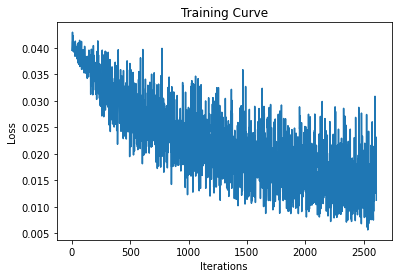

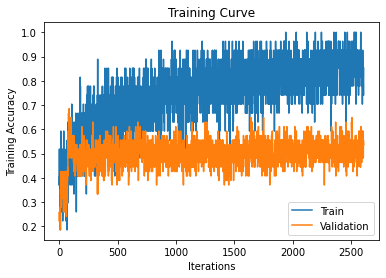

Finished Training
Total time:   881.85 s  Time per Epoch:  29.40 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "base_RNN_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes , batch_size, name)
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp 2 - Changed nonlinearity to relu

Using CUDA
Epoch:  0 Train Accuracy:  0.39676458067262665 Val Accuracy:  0.42592592592592593 Progress:   3.33  % Time Elapsed:  22.04 s 
Epoch 0 Finished.  Time per Epoch:  22.04 s 
Epoch:  1 Train Accuracy:  0.5495955725840783 Val Accuracy:  0.5555555555555556 Progress:   6.67  % Time Elapsed:  44.06 s 
Epoch 1 Finished.  Time per Epoch:  22.03 s 
Epoch:  2 Train Accuracy:  0.6406981694338016 Val Accuracy:  0.5740740740740741 Progress:  10.00  % Time Elapsed:  65.73 s 
Epoch 2 Finished.  Time per Epoch:  21.91 s 
Epoch:  3 Train Accuracy:  0.7015751383567476 Val Accuracy:  0.5740740740740741 Progress:  13.33  % Time Elapsed:  87.10 s 
Epoch 3 Finished.  Time per Epoch:  21.78 s 
Epoch:  4 Train Accuracy:  0.7598978288633461 Val Accuracy:  0.48148148148148145 Progress:  16.67  % Time Elapsed:  108.27 s 
Epoch 4 Finished.  Time per Epoch:  21.65 s 
Epoch:  5 Train Accuracy:  0.8067262664963815 Val Accuracy:  0.5740740740740741 Progress:  20.00  % Time Elapsed:  129.21 s 
Epoch 5 Finishe

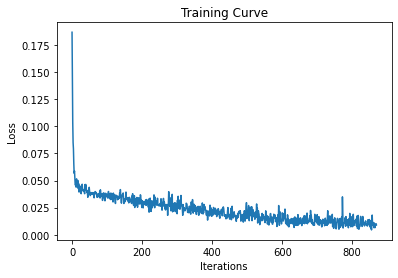

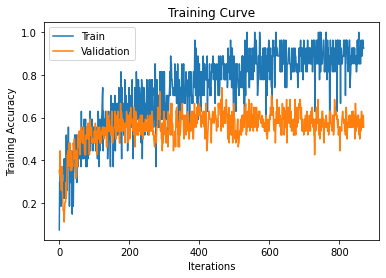

Epoch:  10 Train Accuracy:  0.9157088122605364 Val Accuracy:  0.5185185185185185 Progress:  36.67  % Time Elapsed:  233.33 s 
Epoch 10 Finished.  Time per Epoch:  21.21 s 
Epoch:  11 Train Accuracy:  0.924223073648361 Val Accuracy:  0.5555555555555556 Progress:  40.00  % Time Elapsed:  254.25 s 
Epoch 11 Finished.  Time per Epoch:  21.19 s 
Epoch:  12 Train Accuracy:  0.9323116219667944 Val Accuracy:  0.5 Progress:  43.33  % Time Elapsed:  274.66 s 
Epoch 12 Finished.  Time per Epoch:  21.13 s 
Epoch:  13 Train Accuracy:  0.94465730097914 Val Accuracy:  0.5555555555555556 Progress:  46.67  % Time Elapsed:  295.09 s 
Epoch 13 Finished.  Time per Epoch:  21.08 s 
Epoch:  14 Train Accuracy:  0.955725840783312 Val Accuracy:  0.5555555555555556 Progress:  50.00  % Time Elapsed:  315.53 s 
Epoch 14 Finished.  Time per Epoch:  21.04 s 
Epoch:  15 Train Accuracy:  0.9527458492975734 Val Accuracy:  0.5185185185185185 Progress:  53.33  % Time Elapsed:  336.70 s 
Epoch 15 Finished.  Time per Epoc

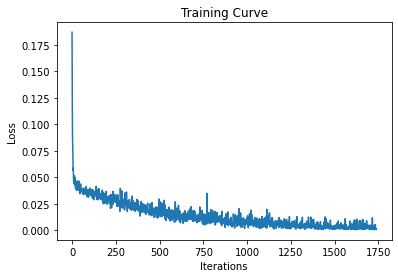

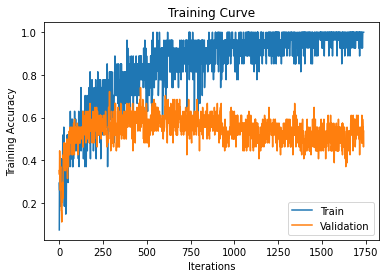

Epoch:  20 Train Accuracy:  0.9833971902937421 Val Accuracy:  0.5370370370370371 Progress:  70.00  % Time Elapsed:  439.48 s 
Epoch 20 Finished.  Time per Epoch:  20.93 s 
Epoch:  21 Train Accuracy:  0.9676458067262665 Val Accuracy:  0.5555555555555556 Progress:  73.33  % Time Elapsed:  460.03 s 
Epoch 21 Finished.  Time per Epoch:  20.91 s 
Epoch:  22 Train Accuracy:  0.9799914857386122 Val Accuracy:  0.5370370370370371 Progress:  76.67  % Time Elapsed:  480.60 s 
Epoch 22 Finished.  Time per Epoch:  20.90 s 
Epoch:  23 Train Accuracy:  0.9863771817794806 Val Accuracy:  0.5370370370370371 Progress:  80.00  % Time Elapsed:  501.22 s 
Epoch 23 Finished.  Time per Epoch:  20.88 s 
Epoch:  24 Train Accuracy:  0.9808429118773946 Val Accuracy:  0.5 Progress:  83.33  % Time Elapsed:  522.22 s 
Epoch 24 Finished.  Time per Epoch:  20.89 s 
Epoch:  25 Train Accuracy:  0.9893571732652192 Val Accuracy:  0.5555555555555556 Progress:  86.67  % Time Elapsed:  542.81 s 
Epoch 25 Finished.  Time per 

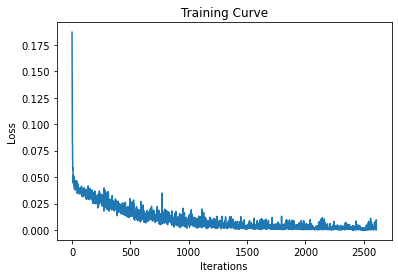

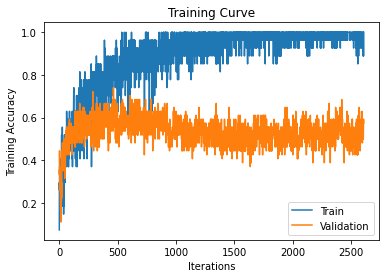

Finished Training
Total time:   625.35 s  Time per Epoch:  20.84 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "base_RNN_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes, batch_size, name, nonlinearity="relu")
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp3 - Expanded fc classifier

In [ ]:
class AccClassRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name, nonlinearity='tanh', dropout=0):
    super(AccClassRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    
    self.fc = nn.Sequential(nn.Linear(hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, num_classes),)
    self.batch_size = batch_size
    self.name = ("AccClassRNN_hiddensize%d_nonlinearity%s_dropout_%f"%(hidden_size, nonlinearity,dropout))
    self.name += name

    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_classes, nonlinearity=nonlinearity, dropout=dropout)

  def forward(self, x):
    # Look up the embedding
    #print(x)
    #print(x.shape)
    #print(x.transpose(1,2).shape)
    #x = np.multiply(self.ident, x)
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

Using CUDA
Epoch:  0 Train Accuracy:  0.37718177948063003 Val Accuracy:  0.35185185185185186 Progress:   3.33  % Time Elapsed:  21.75 s 
Epoch 0 Finished.  Time per Epoch:  21.75 s 
Epoch:  1 Train Accuracy:  0.5053214133673903 Val Accuracy:  0.5370370370370371 Progress:   6.67  % Time Elapsed:  43.36 s 
Epoch 1 Finished.  Time per Epoch:  21.68 s 
Epoch:  2 Train Accuracy:  0.5930183056619838 Val Accuracy:  0.5925925925925926 Progress:  10.00  % Time Elapsed:  64.87 s 
Epoch 2 Finished.  Time per Epoch:  21.62 s 
Epoch:  3 Train Accuracy:  0.6836951894423159 Val Accuracy:  0.5555555555555556 Progress:  13.33  % Time Elapsed:  86.14 s 
Epoch 3 Finished.  Time per Epoch:  21.53 s 
Epoch:  4 Train Accuracy:  0.7254150702426565 Val Accuracy:  0.5740740740740741 Progress:  16.67  % Time Elapsed:  106.95 s 
Epoch 4 Finished.  Time per Epoch:  21.39 s 
Epoch:  5 Train Accuracy:  0.7650063856960408 Val Accuracy:  0.6666666666666666 Progress:  20.00  % Time Elapsed:  127.83 s 
Epoch 5 Finished

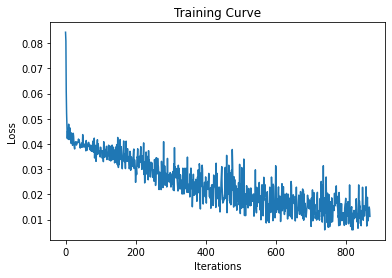

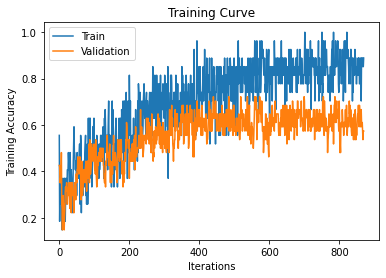

Epoch:  10 Train Accuracy:  0.8748403575989783 Val Accuracy:  0.6481481481481481 Progress:  36.67  % Time Elapsed:  232.24 s 
Epoch 10 Finished.  Time per Epoch:  21.11 s 
Epoch:  11 Train Accuracy:  0.8676032354193274 Val Accuracy:  0.5555555555555556 Progress:  40.00  % Time Elapsed:  252.87 s 
Epoch 11 Finished.  Time per Epoch:  21.07 s 
Epoch:  12 Train Accuracy:  0.887186036611324 Val Accuracy:  0.5740740740740741 Progress:  43.33  % Time Elapsed:  273.49 s 
Epoch 12 Finished.  Time per Epoch:  21.04 s 
Epoch:  13 Train Accuracy:  0.9148573861217539 Val Accuracy:  0.6851851851851852 Progress:  46.67  % Time Elapsed:  294.11 s 
Epoch 13 Finished.  Time per Epoch:  21.01 s 
Epoch:  14 Train Accuracy:  0.9237973605789698 Val Accuracy:  0.6851851851851852 Progress:  50.00  % Time Elapsed:  314.72 s 
Epoch 14 Finished.  Time per Epoch:  20.98 s 
Epoch:  15 Train Accuracy:  0.9293316304810557 Val Accuracy:  0.5925925925925926 Progress:  53.33  % Time Elapsed:  335.34 s 
Epoch 15 Finish

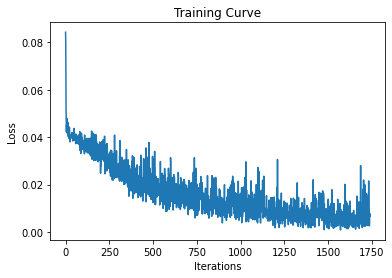

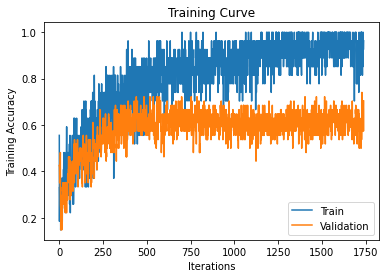

Epoch:  20 Train Accuracy:  0.9591315453384419 Val Accuracy:  0.6296296296296297 Progress:  70.00  % Time Elapsed:  438.50 s 
Epoch 20 Finished.  Time per Epoch:  20.88 s 
Epoch:  21 Train Accuracy:  0.9719029374201787 Val Accuracy:  0.6481481481481481 Progress:  73.33  % Time Elapsed:  459.59 s 
Epoch 21 Finished.  Time per Epoch:  20.89 s 
Epoch:  22 Train Accuracy:  0.9616858237547893 Val Accuracy:  0.6296296296296297 Progress:  76.67  % Time Elapsed:  484.17 s 
Epoch 22 Finished.  Time per Epoch:  21.05 s 
Epoch:  23 Train Accuracy:  0.9838229033631333 Val Accuracy:  0.5555555555555556 Progress:  80.00  % Time Elapsed:  508.66 s 
Epoch 23 Finished.  Time per Epoch:  21.19 s 
Epoch:  24 Train Accuracy:  0.9693486590038314 Val Accuracy:  0.5925925925925926 Progress:  83.33  % Time Elapsed:  532.79 s 
Epoch 24 Finished.  Time per Epoch:  21.31 s 
Epoch:  25 Train Accuracy:  0.9570029799914858 Val Accuracy:  0.6481481481481481 Progress:  86.67  % Time Elapsed:  557.57 s 
Epoch 25 Finis

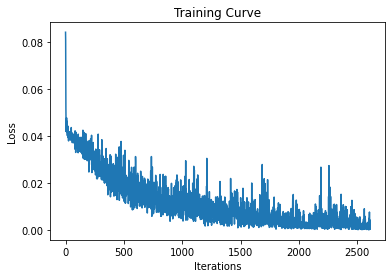

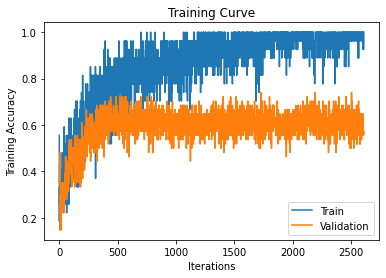

Finished Training
Total time:   656.70 s  Time per Epoch:  21.89 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "data_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes, batch_size, name, nonlinearity="relu")
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp 3 - Bigger fc layers

In [ ]:
class AccClassRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name, nonlinearity='tanh', dropout=0):
    super(AccClassRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    
    self.fc = nn.Sequential(nn.Linear(hidden_size, 20),
                            nn.Linear(20, 10),
                            nn.Linear(10, num_classes),)
    self.batch_size = batch_size
    self.name = ("biggerfcl_AccClassRNN_hiddensize%d_nonlinearity%s_dropout_%f"%(hidden_size, nonlinearity,dropout))
    self.name += name

    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_classes, nonlinearity=nonlinearity, dropout=dropout)

  def forward(self, x):
    # Look up the embedding
    #print(x)
    #print(x.shape)
    #print(x.transpose(1,2).shape)
    #x = np.multiply(self.ident, x)
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

NameError: ignored

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 40
num_classes = 3
name = "data_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes, batch_size, name, nonlinearity="relu")
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Checking Model Performance on raw_10s

In [ ]:
test_net = AccClassRNN(mfcc_bands, hidden_size, num_classes , batch_size, name)
stupid_name = "AccClassRNN_" + name
if torch.cuda.is_available():
    test_net = test_net.cuda()
state = torch.load(os.path.join(model_checkpoints_abs_path, get_model_name(stupid_name, batch_size, learning_rate, "_checkpoint_subdir"), get_model_name(stupid_name, batch_size, learning_rate, 1)))
test_net.load_state_dict(state)

# make a raw train loader
data_transform = transforms.Compose([transforms.ToTensor()])
raw_train_data = torchvision.datasets.DatasetFolder(root=raw_dataset_path, loader=numpy_loader,extensions='.npy',transform=data_transform)
raw_train_loader = torch.utils.data.DataLoader(raw_train_data, batch_size=batch_size, num_workers=1, shuffle=True, drop_last=True)

get_accuracy_rnn(test_net, raw_train_loader)

0.7407407407407407

### Exp 4 - CRNNs (pogging out of our minds)

Using CUDA
Epoch:  0 Train Accuracy:  0.384418901660281 Val Accuracy:  0.3148148148148148 Progress:   3.33  % Time Elapsed:  395.80 s 
Epoch 0 Finished.  Time per Epoch:  395.81 s 
Epoch:  1 Train Accuracy:  0.513835674755215 Val Accuracy:  0.5555555555555556 Progress:   6.67  % Time Elapsed:  414.82 s 
Epoch 1 Finished.  Time per Epoch:  207.41 s 
Epoch:  2 Train Accuracy:  0.6147296722009365 Val Accuracy:  0.5 Progress:  10.00  % Time Elapsed:  433.69 s 
Epoch 2 Finished.  Time per Epoch:  144.56 s 
Epoch:  3 Train Accuracy:  0.6415495955725841 Val Accuracy:  0.6111111111111112 Progress:  13.33  % Time Elapsed:  452.58 s 
Epoch 3 Finished.  Time per Epoch:  113.14 s 
Epoch:  4 Train Accuracy:  0.709663686675181 Val Accuracy:  0.6111111111111112 Progress:  16.67  % Time Elapsed:  471.34 s 
Epoch 4 Finished.  Time per Epoch:  94.27 s 
Epoch:  5 Train Accuracy:  0.7590464027245637 Val Accuracy:  0.6481481481481481 Progress:  20.00  % Time Elapsed:  490.36 s 
Epoch 5 Finished.  Time per 

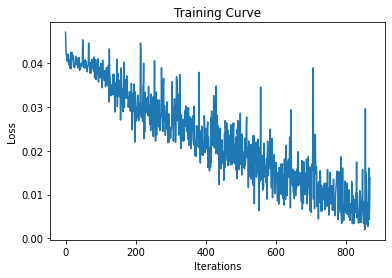

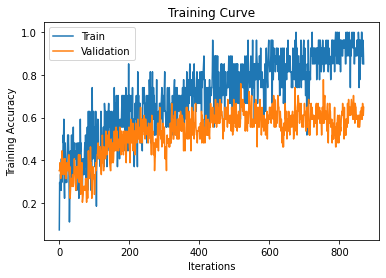

Epoch:  10 Train Accuracy:  0.9365687526607067 Val Accuracy:  0.5925925925925926 Progress:  36.67  % Time Elapsed:  586.03 s 
Epoch 10 Finished.  Time per Epoch:  53.28 s 
Epoch:  11 Train Accuracy:  0.9344401873137506 Val Accuracy:  0.5555555555555556 Progress:  40.00  % Time Elapsed:  604.88 s 
Epoch 11 Finished.  Time per Epoch:  50.41 s 
Epoch:  12 Train Accuracy:  0.9450830140485313 Val Accuracy:  0.6481481481481481 Progress:  43.33  % Time Elapsed:  623.81 s 
Epoch 12 Finished.  Time per Epoch:  47.99 s 
Epoch:  13 Train Accuracy:  0.9731800766283525 Val Accuracy:  0.5740740740740741 Progress:  46.67  % Time Elapsed:  642.81 s 
Epoch 13 Finished.  Time per Epoch:  45.92 s 
Epoch:  14 Train Accuracy:  0.9237973605789698 Val Accuracy:  0.5925925925925926 Progress:  50.00  % Time Elapsed:  661.95 s 
Epoch 14 Finished.  Time per Epoch:  44.13 s 
Epoch:  15 Train Accuracy:  0.9821200510855683 Val Accuracy:  0.5555555555555556 Progress:  53.33  % Time Elapsed:  680.95 s 
Epoch 15 Finis

KeyboardInterrupt: ignored

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
name = "data_ps1and2_gn0.05"

config = {
    "name": "CRNN_first_try",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 40,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp 5 - Beeg CRNN Raw 10s

In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32,64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
name = "data_ps1and2_gn0.05"

config = {
    "name": "CRNN_Beeg_Raw_10s",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 40,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

Using CUDA


RuntimeError: ignored

### Exp 1 (Cat)  - CRNN:

Dataset: raw_3classes_20bands_10s_npy_CRNN

Augmentation: "raw_3classes_20bands_10s_npy_CRNN_augmented_ps1",
                         "3classes_20bands_10s_npy_CRNN_augmented_gn0.07

Architecture: 1 conv layer (32 output, 3 kernel), 50 hidden units, 3 linear layers ( 25 -> 12, 12 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50 


In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 25),
                                nn.Linear(25,12),
                            nn.Linear(12, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.4724724724724725 Val Accuracy:  0.5092592592592593 Progress:   2.00  % Time Elapsed:  200.14 s 
Epoch 0 Finished.  Time per Epoch:  200.14 s 
Epoch:  1 Train Accuracy:  0.5875875875875876 Val Accuracy:  0.6481481481481481 Progress:   4.00  % Time Elapsed:  223.56 s 
Epoch 1 Finished.  Time per Epoch:  111.78 s 
Epoch:  2 Train Accuracy:  0.6906906906906907 Val Accuracy:  0.6851851851851852 Progress:   6.00  % Time Elapsed:  246.64 s 
Epoch 2 Finished.  Time per Epoch:  82.21 s 
Epoch:  3 Train Accuracy:  0.6996996996996997 Val Accuracy:  0.6759259259259259 Progress:   8.00  % Time Elapsed:  270.28 s 
Epoch 3 Finished.  Time per Epoch:  67.57 s 
Epoch:  4 Train Accuracy:  0.7672672672672672 Val Accuracy:  0.5833333333333334 Progress:  10.00  % Time Elapsed:  293.69 s 
Epoch 4 Finished.  Time per Epoch:  58.74 s 


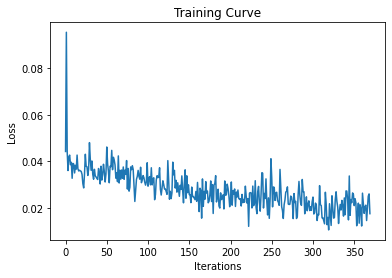

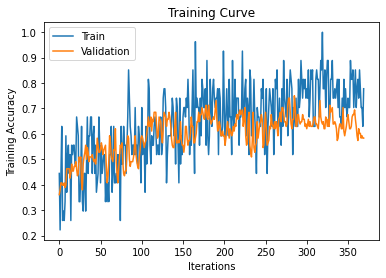

Epoch:  5 Train Accuracy:  0.7907907907907908 Val Accuracy:  0.6296296296296297 Progress:  12.00  % Time Elapsed:  317.23 s 
Epoch 5 Finished.  Time per Epoch:  52.87 s 
Epoch:  6 Train Accuracy:  0.8273273273273273 Val Accuracy:  0.6203703703703703 Progress:  14.00  % Time Elapsed:  341.23 s 
Epoch 6 Finished.  Time per Epoch:  48.75 s 
Epoch:  7 Train Accuracy:  0.8518518518518519 Val Accuracy:  0.6574074074074074 Progress:  16.00  % Time Elapsed:  364.44 s 
Epoch 7 Finished.  Time per Epoch:  45.55 s 
Epoch:  8 Train Accuracy:  0.8748748748748749 Val Accuracy:  0.6574074074074074 Progress:  18.00  % Time Elapsed:  387.55 s 
Epoch 8 Finished.  Time per Epoch:  43.06 s 
Epoch:  9 Train Accuracy:  0.8838838838838838 Val Accuracy:  0.6111111111111112 Progress:  20.00  % Time Elapsed:  410.99 s 
Epoch 9 Finished.  Time per Epoch:  41.10 s 


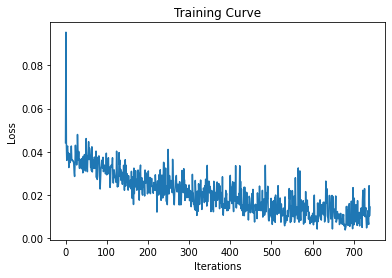

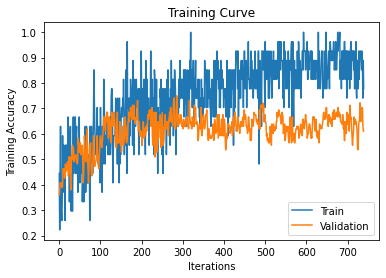

Epoch:  10 Train Accuracy:  0.9069069069069069 Val Accuracy:  0.6759259259259259 Progress:  22.00  % Time Elapsed:  434.58 s 
Epoch 10 Finished.  Time per Epoch:  39.51 s 
Epoch:  11 Train Accuracy:  0.924924924924925 Val Accuracy:  0.6018518518518519 Progress:  24.00  % Time Elapsed:  457.86 s 
Epoch 11 Finished.  Time per Epoch:  38.16 s 
Epoch:  12 Train Accuracy:  0.9244244244244244 Val Accuracy:  0.6574074074074074 Progress:  26.00  % Time Elapsed:  481.31 s 
Epoch 12 Finished.  Time per Epoch:  37.02 s 
Epoch:  13 Train Accuracy:  0.943943943943944 Val Accuracy:  0.6666666666666666 Progress:  28.00  % Time Elapsed:  504.41 s 
Epoch 13 Finished.  Time per Epoch:  36.03 s 
Epoch:  14 Train Accuracy:  0.9519519519519519 Val Accuracy:  0.6296296296296297 Progress:  30.00  % Time Elapsed:  528.04 s 
Epoch 14 Finished.  Time per Epoch:  35.20 s 


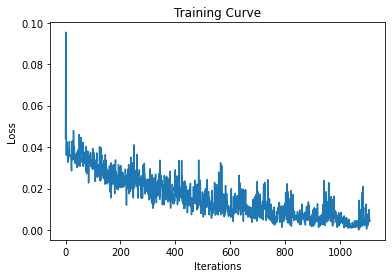

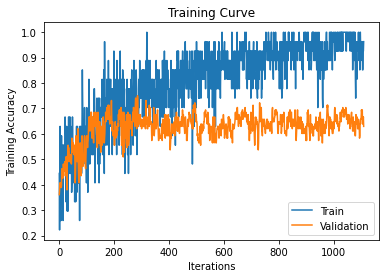

Epoch:  15 Train Accuracy:  0.9409409409409409 Val Accuracy:  0.6759259259259259 Progress:  32.00  % Time Elapsed:  551.65 s 
Epoch 15 Finished.  Time per Epoch:  34.48 s 
Epoch:  16 Train Accuracy:  0.975975975975976 Val Accuracy:  0.6944444444444444 Progress:  34.00  % Time Elapsed:  575.18 s 
Epoch 16 Finished.  Time per Epoch:  33.83 s 
Epoch:  17 Train Accuracy:  0.983983983983984 Val Accuracy:  0.6481481481481481 Progress:  36.00  % Time Elapsed:  598.42 s 
Epoch 17 Finished.  Time per Epoch:  33.25 s 
Epoch:  18 Train Accuracy:  0.98998998998999 Val Accuracy:  0.6574074074074074 Progress:  38.00  % Time Elapsed:  621.62 s 
Epoch 18 Finished.  Time per Epoch:  32.72 s 
Epoch:  19 Train Accuracy:  0.9669669669669669 Val Accuracy:  0.6203703703703703 Progress:  40.00  % Time Elapsed:  645.20 s 
Epoch 19 Finished.  Time per Epoch:  32.26 s 


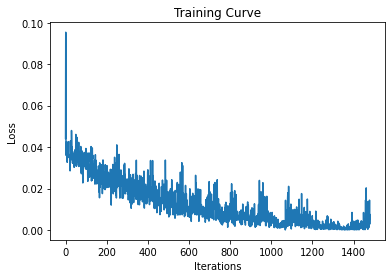

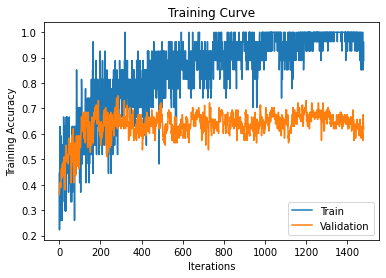

Epoch:  20 Train Accuracy:  0.9424424424424425 Val Accuracy:  0.6203703703703703 Progress:  42.00  % Time Elapsed:  668.96 s 
Epoch 20 Finished.  Time per Epoch:  31.86 s 
Epoch:  21 Train Accuracy:  0.9604604604604604 Val Accuracy:  0.6574074074074074 Progress:  44.00  % Time Elapsed:  692.26 s 
Epoch 21 Finished.  Time per Epoch:  31.47 s 
Epoch:  22 Train Accuracy:  0.9474474474474475 Val Accuracy:  0.7129629629629629 Progress:  46.00  % Time Elapsed:  715.31 s 
Epoch 22 Finished.  Time per Epoch:  31.10 s 
Epoch:  23 Train Accuracy:  0.9854854854854855 Val Accuracy:  0.5833333333333334 Progress:  48.00  % Time Elapsed:  738.44 s 
Epoch 23 Finished.  Time per Epoch:  30.77 s 
Epoch:  24 Train Accuracy:  0.9874874874874875 Val Accuracy:  0.6851851851851852 Progress:  50.00  % Time Elapsed:  761.27 s 
Epoch 24 Finished.  Time per Epoch:  30.45 s 


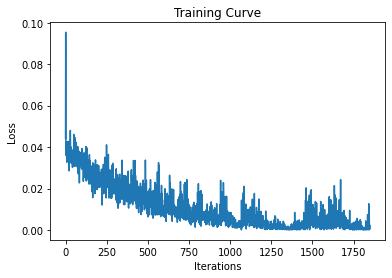

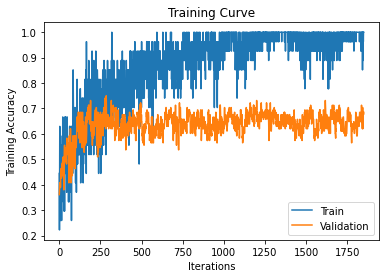

Epoch:  25 Train Accuracy:  0.996996996996997 Val Accuracy:  0.6574074074074074 Progress:  52.00  % Time Elapsed:  784.71 s 
Epoch 25 Finished.  Time per Epoch:  30.18 s 
Epoch:  26 Train Accuracy:  0.9994994994994995 Val Accuracy:  0.6666666666666666 Progress:  54.00  % Time Elapsed:  807.67 s 
Epoch 26 Finished.  Time per Epoch:  29.91 s 
Epoch:  27 Train Accuracy:  1.0 Val Accuracy:  0.6944444444444444 Progress:  56.00  % Time Elapsed:  830.85 s 
Epoch 27 Finished.  Time per Epoch:  29.67 s 
Epoch:  28 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  58.00  % Time Elapsed:  854.04 s 
Epoch 28 Finished.  Time per Epoch:  29.45 s 
Epoch:  29 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  60.00  % Time Elapsed:  877.54 s 
Epoch 29 Finished.  Time per Epoch:  29.25 s 


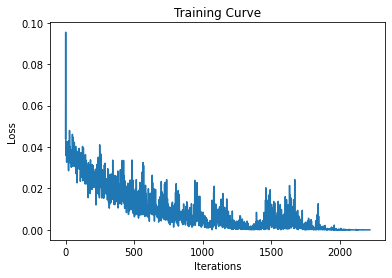

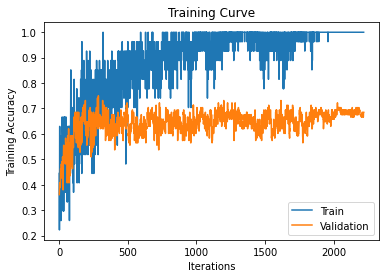

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  62.00  % Time Elapsed:  900.61 s 
Epoch 30 Finished.  Time per Epoch:  29.05 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.6759259259259259 Progress:  64.00  % Time Elapsed:  923.58 s 
Epoch 31 Finished.  Time per Epoch:  28.86 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  66.00  % Time Elapsed:  946.83 s 
Epoch 32 Finished.  Time per Epoch:  28.69 s 
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  68.00  % Time Elapsed:  970.58 s 
Epoch 33 Finished.  Time per Epoch:  28.55 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  70.00  % Time Elapsed:  993.76 s 
Epoch 34 Finished.  Time per Epoch:  28.39 s 


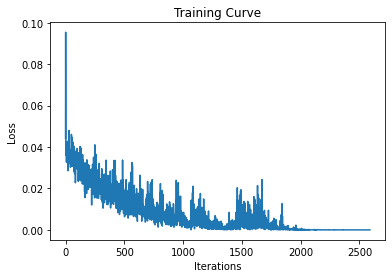

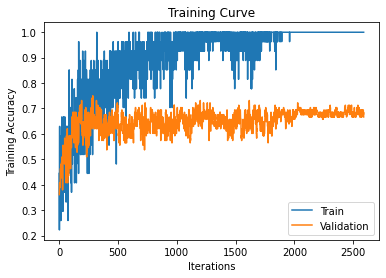

Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.6944444444444444 Progress:  72.00  % Time Elapsed:  1017.20 s 
Epoch 35 Finished.  Time per Epoch:  28.26 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  74.00  % Time Elapsed:  1040.31 s 
Epoch 36 Finished.  Time per Epoch:  28.12 s 
Epoch:  37 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  76.00  % Time Elapsed:  1063.44 s 
Epoch 37 Finished.  Time per Epoch:  27.99 s 
Epoch:  38 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  78.00  % Time Elapsed:  1086.64 s 
Epoch 38 Finished.  Time per Epoch:  27.86 s 
Epoch:  39 Train Accuracy:  1.0 Val Accuracy:  0.7129629629629629 Progress:  80.00  % Time Elapsed:  1110.15 s 
Epoch 39 Finished.  Time per Epoch:  27.75 s 


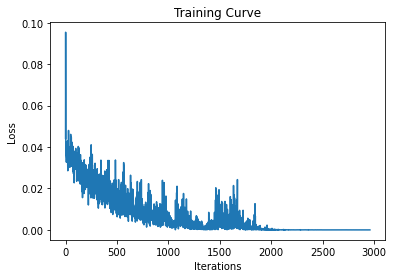

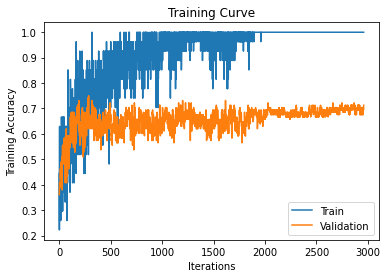

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.6944444444444444 Progress:  82.00  % Time Elapsed:  1133.57 s 
Epoch 40 Finished.  Time per Epoch:  27.65 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.6944444444444444 Progress:  84.00  % Time Elapsed:  1156.47 s 
Epoch 41 Finished.  Time per Epoch:  27.54 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.6944444444444444 Progress:  86.00  % Time Elapsed:  1179.84 s 
Epoch 42 Finished.  Time per Epoch:  27.44 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.6944444444444444 Progress:  88.00  % Time Elapsed:  1202.59 s 
Epoch 43 Finished.  Time per Epoch:  27.33 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.7129629629629629 Progress:  90.00  % Time Elapsed:  1225.33 s 
Epoch 44 Finished.  Time per Epoch:  27.23 s 


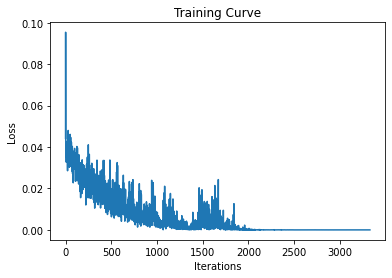

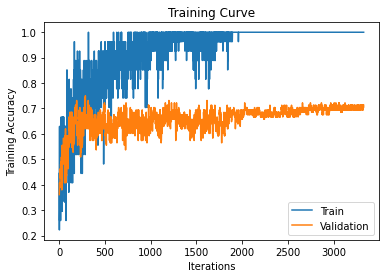

Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  92.00  % Time Elapsed:  1248.41 s 
Epoch 45 Finished.  Time per Epoch:  27.14 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  94.00  % Time Elapsed:  1271.91 s 
Epoch 46 Finished.  Time per Epoch:  27.06 s 
Epoch:  47 Train Accuracy:  1.0 Val Accuracy:  0.7129629629629629 Progress:  96.00  % Time Elapsed:  1294.65 s 
Epoch 47 Finished.  Time per Epoch:  26.97 s 
Epoch:  48 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  98.00  % Time Elapsed:  1317.65 s 
Epoch 48 Finished.  Time per Epoch:  26.89 s 
Epoch:  49 Train Accuracy:  1.0 Val Accuracy:  0.7129629629629629 Progress:  100.00  % Time Elapsed:  1340.56 s 
Epoch 49 Finished.  Time per Epoch:  26.81 s 


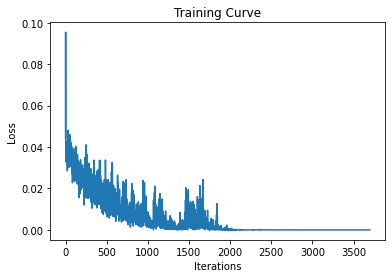

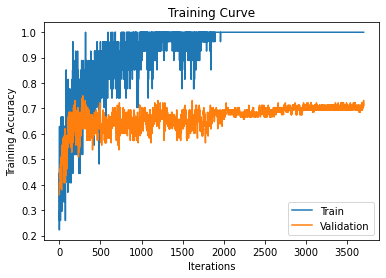

Finished Training
Total time:   1340.86 s  Time per Epoch:  26.82 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005
name = "data_ps1and2_gn0.05_new"
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_10s_70_val_accuracy_20bands_with_ps1_gn0.07",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net_4 = CRNN(config)
train_crnn_net(acc_net_4, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 2 - CRNN (RAW)

Dataset: raw_3classes_20bands_10s_npy_CRNN

Augmentation: None 

Architecture: 1 conv layer (32 output, 3 kernel), 50 hidden units, 3 linear layers ( 25 -> 12, 12 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.3786008230452675 Val Accuracy:  0.3425925925925926 Progress:   2.00  % Time Elapsed:   6.02 s 
Epoch 0 Finished.  Time per Epoch:   6.02 s 
Epoch:  1 Train Accuracy:  0.3477366255144033 Val Accuracy:  0.3611111111111111 Progress:   4.00  % Time Elapsed:  12.06 s 
Epoch 1 Finished.  Time per Epoch:   6.03 s 
Epoch:  2 Train Accuracy:  0.3991769547325103 Val Accuracy:  0.3888888888888889 Progress:   6.00  % Time Elapsed:  18.31 s 
Epoch 2 Finished.  Time per Epoch:   6.10 s 
Epoch:  3 Train Accuracy:  0.4156378600823045 Val Accuracy:  0.39814814814814814 Progress:   8.00  % Time Elapsed:  24.34 s 
Epoch 3 Finished.  Time per Epoch:   6.09 s 
Epoch:  4 Train Accuracy:  0.4547325102880658 Val Accuracy:  0.4074074074074074 Progress:  10.00  % Time Elapsed:  30.39 s 
Epoch 4 Finished.  Time per Epoch:   6.08 s 


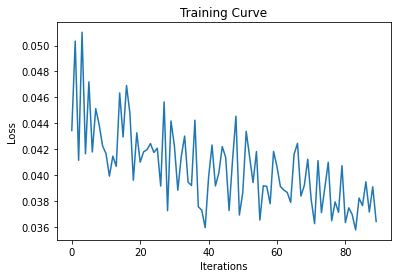

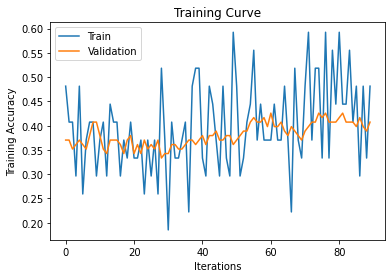

Epoch:  5 Train Accuracy:  0.4691358024691358 Val Accuracy:  0.4166666666666667 Progress:  12.00  % Time Elapsed:  36.62 s 
Epoch 5 Finished.  Time per Epoch:   6.10 s 
Epoch:  6 Train Accuracy:  0.5 Val Accuracy:  0.4537037037037037 Progress:  14.00  % Time Elapsed:  42.59 s 
Epoch 6 Finished.  Time per Epoch:   6.08 s 
Epoch:  7 Train Accuracy:  0.5576131687242798 Val Accuracy:  0.42592592592592593 Progress:  16.00  % Time Elapsed:  48.55 s 
Epoch 7 Finished.  Time per Epoch:   6.07 s 
Epoch:  8 Train Accuracy:  0.551440329218107 Val Accuracy:  0.5 Progress:  18.00  % Time Elapsed:  54.45 s 
Epoch 8 Finished.  Time per Epoch:   6.05 s 
Epoch:  9 Train Accuracy:  0.5761316872427984 Val Accuracy:  0.4722222222222222 Progress:  20.00  % Time Elapsed:  60.52 s 
Epoch 9 Finished.  Time per Epoch:   6.05 s 


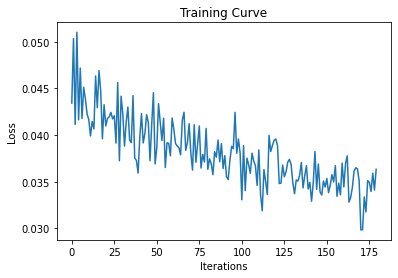

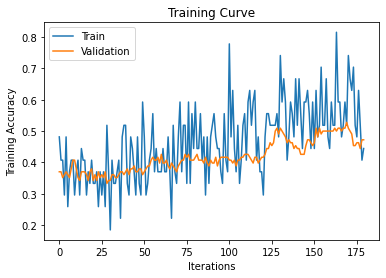

Epoch:  10 Train Accuracy:  0.5843621399176955 Val Accuracy:  0.5277777777777778 Progress:  22.00  % Time Elapsed:  66.87 s 
Epoch 10 Finished.  Time per Epoch:   6.08 s 
Epoch:  11 Train Accuracy:  0.5843621399176955 Val Accuracy:  0.4444444444444444 Progress:  24.00  % Time Elapsed:  72.95 s 
Epoch 11 Finished.  Time per Epoch:   6.08 s 
Epoch:  12 Train Accuracy:  0.6090534979423868 Val Accuracy:  0.5462962962962963 Progress:  26.00  % Time Elapsed:  78.93 s 
Epoch 12 Finished.  Time per Epoch:   6.07 s 
Epoch:  13 Train Accuracy:  0.6275720164609053 Val Accuracy:  0.5 Progress:  28.00  % Time Elapsed:  84.88 s 
Epoch 13 Finished.  Time per Epoch:   6.06 s 
Epoch:  14 Train Accuracy:  0.602880658436214 Val Accuracy:  0.5925925925925926 Progress:  30.00  % Time Elapsed:  90.82 s 
Epoch 14 Finished.  Time per Epoch:   6.05 s 


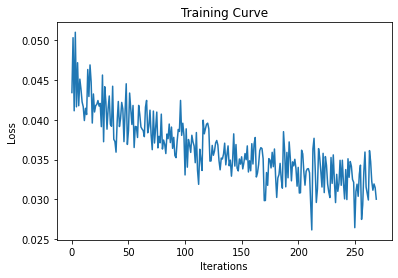

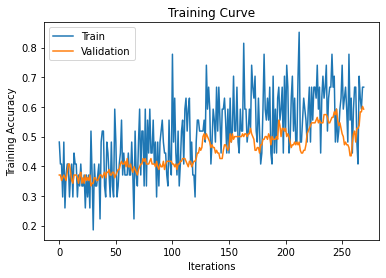

Epoch:  15 Train Accuracy:  0.6275720164609053 Val Accuracy:  0.5185185185185185 Progress:  32.00  % Time Elapsed:  97.13 s 
Epoch 15 Finished.  Time per Epoch:   6.07 s 
Epoch:  16 Train Accuracy:  0.6275720164609053 Val Accuracy:  0.5462962962962963 Progress:  34.00  % Time Elapsed:  103.15 s 
Epoch 16 Finished.  Time per Epoch:   6.07 s 
Epoch:  17 Train Accuracy:  0.6481481481481481 Val Accuracy:  0.5925925925925926 Progress:  36.00  % Time Elapsed:  109.22 s 
Epoch 17 Finished.  Time per Epoch:   6.07 s 
Epoch:  18 Train Accuracy:  0.6337448559670782 Val Accuracy:  0.5555555555555556 Progress:  38.00  % Time Elapsed:  115.18 s 
Epoch 18 Finished.  Time per Epoch:   6.06 s 
Epoch:  19 Train Accuracy:  0.6584362139917695 Val Accuracy:  0.5277777777777778 Progress:  40.00  % Time Elapsed:  121.23 s 
Epoch 19 Finished.  Time per Epoch:   6.06 s 


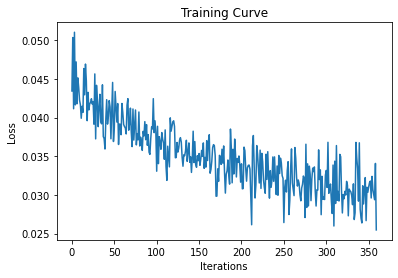

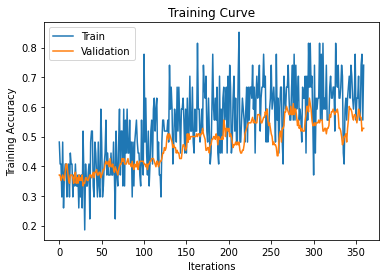

Epoch:  20 Train Accuracy:  0.6481481481481481 Val Accuracy:  0.5185185185185185 Progress:  42.00  % Time Elapsed:  127.52 s 
Epoch 20 Finished.  Time per Epoch:   6.07 s 
Epoch:  21 Train Accuracy:  0.6419753086419753 Val Accuracy:  0.5925925925925926 Progress:  44.00  % Time Elapsed:  133.53 s 
Epoch 21 Finished.  Time per Epoch:   6.07 s 
Epoch:  22 Train Accuracy:  0.6790123456790124 Val Accuracy:  0.5 Progress:  46.00  % Time Elapsed:  139.52 s 
Epoch 22 Finished.  Time per Epoch:   6.07 s 
Epoch:  23 Train Accuracy:  0.6604938271604939 Val Accuracy:  0.5740740740740741 Progress:  48.00  % Time Elapsed:  145.49 s 
Epoch 23 Finished.  Time per Epoch:   6.06 s 
Epoch:  24 Train Accuracy:  0.6872427983539094 Val Accuracy:  0.5648148148148148 Progress:  50.00  % Time Elapsed:  151.78 s 
Epoch 24 Finished.  Time per Epoch:   6.07 s 


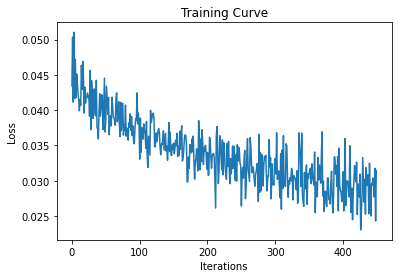

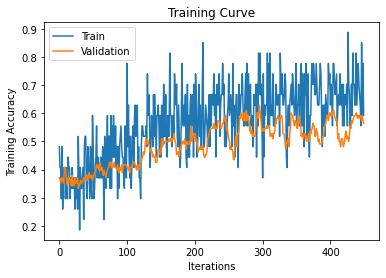

Epoch:  25 Train Accuracy:  0.6728395061728395 Val Accuracy:  0.5648148148148148 Progress:  52.00  % Time Elapsed:  158.59 s 
Epoch 25 Finished.  Time per Epoch:   6.10 s 
Epoch:  26 Train Accuracy:  0.6872427983539094 Val Accuracy:  0.5277777777777778 Progress:  54.00  % Time Elapsed:  164.64 s 
Epoch 26 Finished.  Time per Epoch:   6.10 s 
Epoch:  27 Train Accuracy:  0.668724279835391 Val Accuracy:  0.5648148148148148 Progress:  56.00  % Time Elapsed:  170.60 s 
Epoch 27 Finished.  Time per Epoch:   6.09 s 
Epoch:  28 Train Accuracy:  0.6975308641975309 Val Accuracy:  0.5648148148148148 Progress:  58.00  % Time Elapsed:  176.54 s 
Epoch 28 Finished.  Time per Epoch:   6.09 s 
Epoch:  29 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.5462962962962963 Progress:  60.00  % Time Elapsed:  182.51 s 
Epoch 29 Finished.  Time per Epoch:   6.08 s 


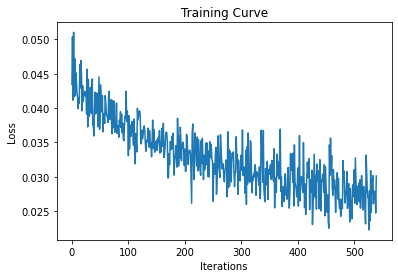

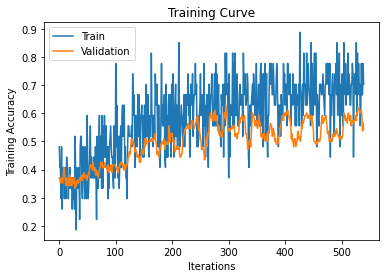

Epoch:  30 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.5740740740740741 Progress:  62.00  % Time Elapsed:  188.73 s 
Epoch 30 Finished.  Time per Epoch:   6.09 s 
Epoch:  31 Train Accuracy:  0.6954732510288066 Val Accuracy:  0.5740740740740741 Progress:  64.00  % Time Elapsed:  194.75 s 
Epoch 31 Finished.  Time per Epoch:   6.09 s 
Epoch:  32 Train Accuracy:  0.720164609053498 Val Accuracy:  0.5925925925925926 Progress:  66.00  % Time Elapsed:  200.83 s 
Epoch 32 Finished.  Time per Epoch:   6.09 s 
Epoch:  33 Train Accuracy:  0.6995884773662552 Val Accuracy:  0.5 Progress:  68.00  % Time Elapsed:  206.79 s 
Epoch 33 Finished.  Time per Epoch:   6.08 s 
Epoch:  34 Train Accuracy:  0.7098765432098766 Val Accuracy:  0.6296296296296297 Progress:  70.00  % Time Elapsed:  212.80 s 
Epoch 34 Finished.  Time per Epoch:   6.08 s 


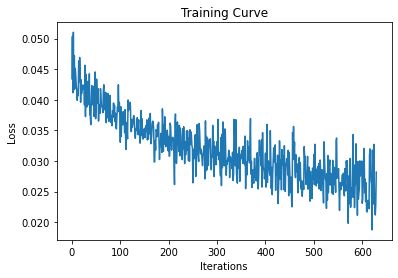

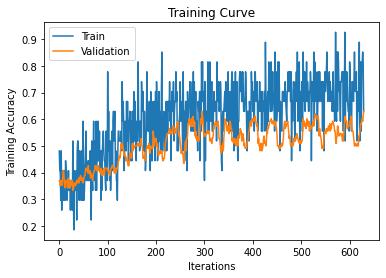

Epoch:  35 Train Accuracy:  0.7345679012345679 Val Accuracy:  0.5833333333333334 Progress:  72.00  % Time Elapsed:  219.20 s 
Epoch 35 Finished.  Time per Epoch:   6.09 s 
Epoch:  36 Train Accuracy:  0.7489711934156379 Val Accuracy:  0.5740740740740741 Progress:  74.00  % Time Elapsed:  225.27 s 
Epoch 36 Finished.  Time per Epoch:   6.09 s 
Epoch:  37 Train Accuracy:  0.7304526748971193 Val Accuracy:  0.6111111111111112 Progress:  76.00  % Time Elapsed:  231.31 s 
Epoch 37 Finished.  Time per Epoch:   6.09 s 
Epoch:  38 Train Accuracy:  0.7654320987654321 Val Accuracy:  0.6111111111111112 Progress:  78.00  % Time Elapsed:  237.31 s 
Epoch 38 Finished.  Time per Epoch:   6.08 s 
Epoch:  39 Train Accuracy:  0.7818930041152263 Val Accuracy:  0.5277777777777778 Progress:  80.00  % Time Elapsed:  243.20 s 
Epoch 39 Finished.  Time per Epoch:   6.08 s 


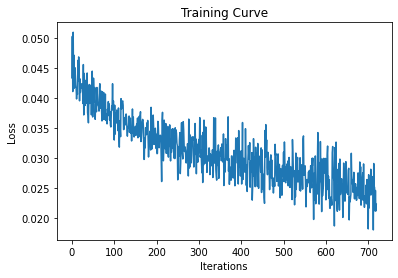

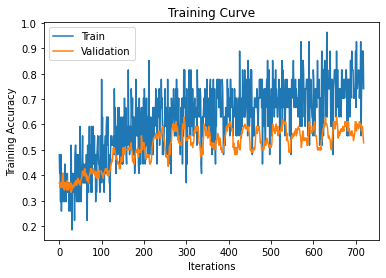

Epoch:  40 Train Accuracy:  0.7757201646090535 Val Accuracy:  0.5833333333333334 Progress:  82.00  % Time Elapsed:  249.54 s 
Epoch 40 Finished.  Time per Epoch:   6.09 s 
Epoch:  41 Train Accuracy:  0.7592592592592593 Val Accuracy:  0.5833333333333334 Progress:  84.00  % Time Elapsed:  255.53 s 
Epoch 41 Finished.  Time per Epoch:   6.08 s 
Epoch:  42 Train Accuracy:  0.7654320987654321 Val Accuracy:  0.5833333333333334 Progress:  86.00  % Time Elapsed:  261.47 s 
Epoch 42 Finished.  Time per Epoch:   6.08 s 
Epoch:  43 Train Accuracy:  0.7818930041152263 Val Accuracy:  0.5648148148148148 Progress:  88.00  % Time Elapsed:  267.45 s 
Epoch 43 Finished.  Time per Epoch:   6.08 s 
Epoch:  44 Train Accuracy:  0.7736625514403292 Val Accuracy:  0.5925925925925926 Progress:  90.00  % Time Elapsed:  273.45 s 
Epoch 44 Finished.  Time per Epoch:   6.08 s 


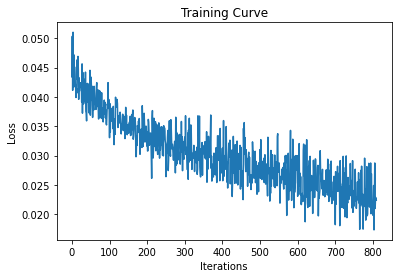

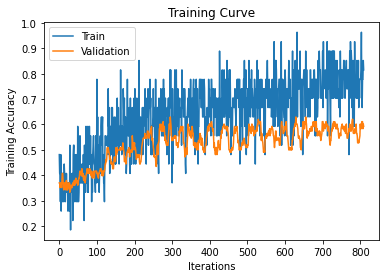

Epoch:  45 Train Accuracy:  0.779835390946502 Val Accuracy:  0.5740740740740741 Progress:  92.00  % Time Elapsed:  279.73 s 
Epoch 45 Finished.  Time per Epoch:   6.08 s 
Epoch:  46 Train Accuracy:  0.7942386831275721 Val Accuracy:  0.5555555555555556 Progress:  94.00  % Time Elapsed:  285.68 s 
Epoch 46 Finished.  Time per Epoch:   6.08 s 
Epoch:  47 Train Accuracy:  0.8004115226337448 Val Accuracy:  0.5833333333333334 Progress:  96.00  % Time Elapsed:  291.63 s 
Epoch 47 Finished.  Time per Epoch:   6.08 s 
Epoch:  48 Train Accuracy:  0.7942386831275721 Val Accuracy:  0.5740740740740741 Progress:  98.00  % Time Elapsed:  297.67 s 
Epoch 48 Finished.  Time per Epoch:   6.07 s 
Epoch:  49 Train Accuracy:  0.8106995884773662 Val Accuracy:  0.5462962962962963 Progress:  100.00  % Time Elapsed:  303.67 s 
Epoch 49 Finished.  Time per Epoch:   6.07 s 


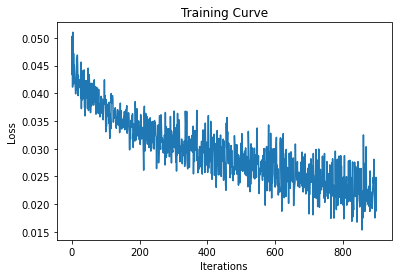

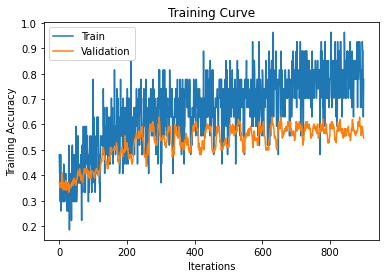

Finished Training
Total time:   303.97 s  Time per Epoch:   6.08 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_best_raw_10s_20bands",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net_4 = CRNN(config)
train_crnn_net(acc_net_4, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 3 - CRNN: Previous Split 

Dataset: raw_10s_3classes_npy

Augmentation: "ps_1_dur_10_npy",
                         "ps_1_dur_10_npy",
                         "gn_0.05_dur_10_npy" 

Architecture: 1 conv layer (16,32 output, 3 kernel), 50 hidden units, 3 linear layers ( 20 -> 10, 10 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.39651416122004357 Val Accuracy:  0.3888888888888889 Progress:   2.00  % Time Elapsed:  102.83 s 
Epoch 0 Finished.  Time per Epoch:  102.83 s 
Epoch:  1 Train Accuracy:  0.39215686274509803 Val Accuracy:  0.3333333333333333 Progress:   4.00  % Time Elapsed:  107.48 s 
Epoch 1 Finished.  Time per Epoch:  53.74 s 
Epoch:  2 Train Accuracy:  0.4095860566448802 Val Accuracy:  0.3148148148148148 Progress:   6.00  % Time Elapsed:  111.43 s 
Epoch 2 Finished.  Time per Epoch:  37.14 s 
Epoch:  3 Train Accuracy:  0.40522875816993464 Val Accuracy:  0.3148148148148148 Progress:   8.00  % Time Elapsed:  115.40 s 
Epoch 3 Finished.  Time per Epoch:  28.85 s 
Epoch:  4 Train Accuracy:  0.4117647058823529 Val Accuracy:  0.3148148148148148 Progress:  10.00  % Time Elapsed:  119.28 s 
Epoch 4 Finished.  Time per Epoch:  23.86 s 
Epoch:  5 Train Accuracy:  0.42701525054466233 Val Accuracy:  0.25925925925925924 Progress:  12.00  % Time Elapsed:  123.24 s 
Epoch 5 

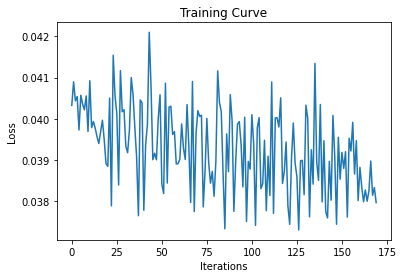

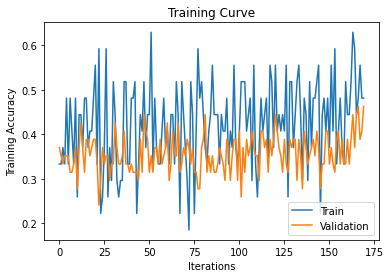

Epoch:  10 Train Accuracy:  0.47058823529411764 Val Accuracy:  0.35185185185185186 Progress:  22.00  % Time Elapsed:  143.14 s 
Epoch 10 Finished.  Time per Epoch:  13.01 s 
Epoch:  11 Train Accuracy:  0.485838779956427 Val Accuracy:  0.4074074074074074 Progress:  24.00  % Time Elapsed:  147.12 s 
Epoch 11 Finished.  Time per Epoch:  12.26 s 
Epoch:  12 Train Accuracy:  0.48366013071895425 Val Accuracy:  0.4444444444444444 Progress:  26.00  % Time Elapsed:  150.99 s 
Epoch 12 Finished.  Time per Epoch:  11.61 s 
Epoch:  13 Train Accuracy:  0.4989106753812636 Val Accuracy:  0.35185185185185186 Progress:  28.00  % Time Elapsed:  154.85 s 
Epoch 13 Finished.  Time per Epoch:  11.06 s 
Epoch:  14 Train Accuracy:  0.4989106753812636 Val Accuracy:  0.4074074074074074 Progress:  30.00  % Time Elapsed:  158.74 s 
Epoch 14 Finished.  Time per Epoch:  10.58 s 
Epoch:  15 Train Accuracy:  0.5163398692810458 Val Accuracy:  0.5370370370370371 Progress:  32.00  % Time Elapsed:  162.57 s 
Epoch 15 Fi

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_best_raw_10s_20bands",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)